# Citation Prediction EDA & Model Selection

This notebook analyzes the relationship between paper metadata and citation counts to determine the best features for our prediction model.

## Goals
1. Analyze citation distribution.
2. Identify correlation between features (Author count, Abstract length, etc.) and Citations.
3. Train baseline XGBoost model to feature importance.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

%matplotlib inline
sns.set_theme(style="whitegrid")

In [5]:
# Load Data
df = pd.read_csv("../data/eda_papers.csv")
print(f"Loaded {len(df)} papers.")
df.head()

Loaded 102215 papers.


,arxiv_id,title,abstract,authors,primary_category,all_categories,published_at,citation_count
0,2511.01118,Generative Machine Learning Models for the Dec...,Charge carrier dynamics critically affect the ...,Li Raymond|Salim Flora|Wang Sijin|Wright Brendan,cond-mat.mtrl-sci,cond-mat.mtrl-sci|cs.LG,2025-11-02T23:32:05+00:00,0
1,2511.01113,S2Doc -- Spatial-Semantic Document Format,Documents are a common way to store and share ...,Sebastian Kempf|Frank Puppe,cs.DL,cs.DL|cs.CL,2025-11-02T23:06:03+00:00,0
2,2511.01109,Anatomically Constrained Transformers for Echo...,Video transformers have recently demonstrated ...,Alexander Thorley|Agis Chartsias|Jordan Strom|...,cs.CV,cs.CV,2025-11-02T22:52:30+00:00,0
3,2511.01107,SLAP: Shortcut Learning for Abstract Planning,Long-horizon decision-making with sparse rewar...,Y. Isabel Liu|Bowen Li|Benjamin Eysenbach|Tom ...,cs.RO,cs.RO|cs.LG,2025-11-02T22:48:31+00:00,1
4,2511.01104,HarnessLLM: Automatic Testing Harness Generati...,Existing LLM-based automatic test generation m...,Yujian Liu|Jiabao Ji|Yang Zhang|Wenbo Guo|Tomm...,cs.SE,cs.SE|cs.CL,2025-11-02T22:41:15+00:00,0


In [6]:
df.describe()

,arxiv_id,citation_count
count,102215.000000,102215.000000
mean,2511.763336,2.615927
std,20.232665,18.954027
min,2502.053870,0.000000
25%,2505.080830,0.000000
50%,2507.228110,0.000000
75%,2510.177800,2.000000
max,2602.038520,3176.000000


<Axes: >

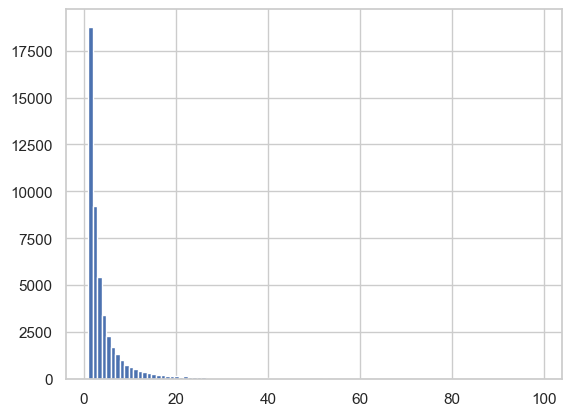

In [7]:
df[(df['citation_count'] > 0) & (df['citation_count'] < 100)]['citation_count'].hist(bins=100)


In [8]:
counts_df = (
    df['citation_count']
    .value_counts()
    .reset_index()
)

In [9]:
counts_df.head(20)

,citation_count,count
0,0,53136
1,1,18777
2,2,9222
3,3,5415
4,4,3392
5,5,2284
6,6,1695
7,7,1311
8,8,979
9,9,739


## 1. Feature Engineering
We extract simple features from metadata:
- Title Length
- Abstract Length
- Number of Authors
- Primary Category
- Days since publication (Age)

In [10]:
df['published_at'] = pd.to_datetime(df['published_at'])
df['age_days'] = (pd.Timestamp.now(tz='UTC') - df['published_at']).dt.days

# Text features
df['title_len'] = df['title'].apply(len)
df['abstract_len'] = df['abstract'].apply(len)

# Author count (splitting by pipe)
df['num_authors'] = df['authors'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) else 0)

# Filter out very new papers if needed (though API query handled this)
df = df[df['age_days'] > 30]

df[['title_len', 'abstract_len', 'num_authors', 'age_days', 'citation_count']].describe()

,title_len,abstract_len,num_authors,age_days,citation_count
count,100371.000000,100371.000000,100371.000000,100371.000000,100371.000000
mean,82.836048,1320.094898,5.413237,201.257246,2.659573
std,23.157038,308.012000,12.636427,96.045714,19.122211
min,5.000000,51.000000,1.000000,31.000000,0.000000
25%,68.000000,1109.000000,3.000000,120.000000,0.000000
50%,82.000000,1320.000000,5.000000,201.000000,0.000000
75%,97.000000,1538.000000,6.000000,278.000000,2.000000
max,240.000000,3488.000000,3435.000000,369.000000,3176.000000


In [11]:
df.head()

,arxiv_id,title,abstract,authors,primary_category,all_categories,published_at,citation_count,age_days,title_len,abstract_len,num_authors
0,2511.01118,Generative Machine Learning Models for the Dec...,Charge carrier dynamics critically affect the ...,Li Raymond|Salim Flora|Wang Sijin|Wright Brendan,cond-mat.mtrl-sci,cond-mat.mtrl-sci|cs.LG,2025-11-02 23:32:05+00:00,0,101,113,830,4
1,2511.01113,S2Doc -- Spatial-Semantic Document Format,Documents are a common way to store and share ...,Sebastian Kempf|Frank Puppe,cs.DL,cs.DL|cs.CL,2025-11-02 23:06:03+00:00,0,101,41,990,2
2,2511.01109,Anatomically Constrained Transformers for Echo...,Video transformers have recently demonstrated ...,Alexander Thorley|Agis Chartsias|Jordan Strom|...,cs.CV,cs.CV,2025-11-02 22:52:30+00:00,0,101,65,1483,7
3,2511.01107,SLAP: Shortcut Learning for Abstract Planning,Long-horizon decision-making with sparse rewar...,Y. Isabel Liu|Bowen Li|Benjamin Eysenbach|Tom ...,cs.RO,cs.RO|cs.LG,2025-11-02 22:48:31+00:00,1,101,45,1268,4
4,2511.01104,HarnessLLM: Automatic Testing Harness Generati...,Existing LLM-based automatic test generation m...,Yujian Liu|Jiabao Ji|Yang Zhang|Wenbo Guo|Tomm...,cs.SE,cs.SE|cs.CL,2025-11-02 22:41:15+00:00,0,101,75,1004,6


In [12]:
df['age_bin'] = (df['age_days'] // 7) * 7

n_age_df = df.groupby('age_bin').agg(
    mean=('citation_count', 'mean')
)
n_age_df.head()

,mean
age_bin,
28,0.155022
35,0.255381
42,0.335227
49,0.489362
56,0.421941


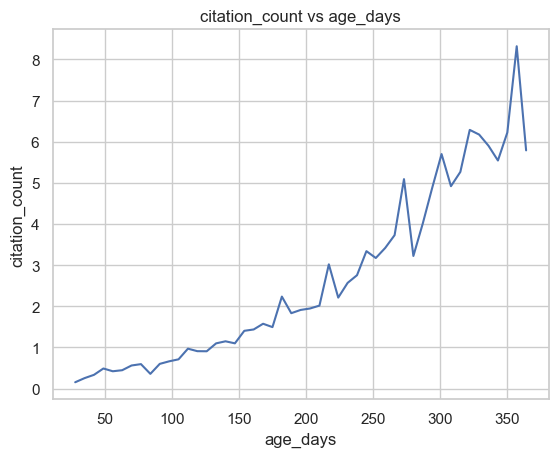

In [13]:
n_age_df['mean'].plot()

plt.xlabel("age_days")
plt.ylabel("citation_count")
plt.title("citation_count vs age_days")
plt.show()

In [14]:
bins = [0, 1, 5, 20, 100, 1000, df['citation_count'].max()]
labels = ['0', '1-5', '5-20', '20-100', '100-1000', '1000+']


df['popularity_bucket'] = pd.cut(
    df['citation_count'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

trend_df = (
    df.groupby(['age_bin', 'popularity_bucket'])
      .agg(
          count=('citation_count', 'size')
      )
      .reset_index()
)


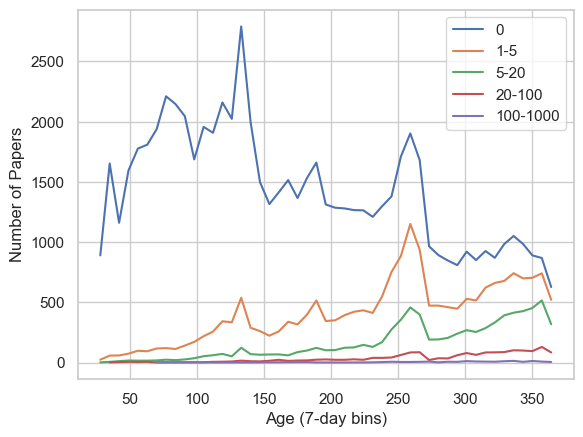

In [15]:
labels_remove_outliers = ['0', '1-5', '5-20', '20-100', '100-1000']

for bucket in labels_remove_outliers:
    subset = trend_df[trend_df['popularity_bucket'] == bucket]
    plt.plot(subset['age_bin'], subset['count'], label=bucket)

plt.xlabel("Age (7-day bins)")
plt.ylabel("Number of Papers")
plt.legend()
plt.show()


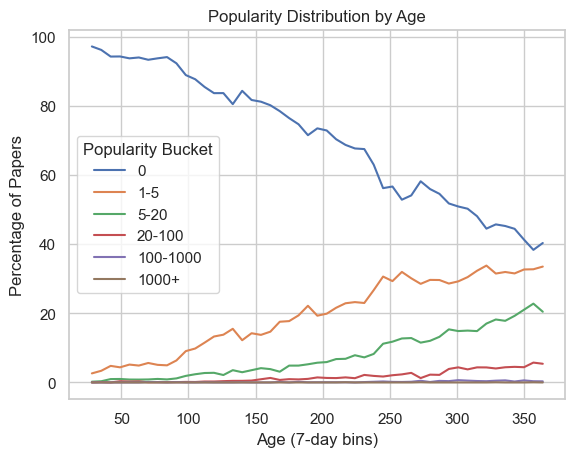

In [16]:
pivot_df = (
    df.groupby(['age_bin', 'popularity_bucket'])
      .size()
      .unstack(fill_value=0)
)

# Convert counts → percentage within each age_bin
pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0)

pivot_pct = pivot_pct * 100

pivot_pct.plot()

plt.xlabel("Age (7-day bins)")
plt.ylabel("Percentage of Papers")
plt.title("Popularity Distribution by Age")
plt.legend(title="Popularity Bucket")
plt.show()


## Dynamically Adjust Bin Size

In [17]:
c1 = 0.06
c2 = 0.12

# Ensure age_bin is numeric for this calculation to work
mid_threshold = df['age_bin'] * c1
high_threshold = df['age_bin'] * c2

conditions = [
    df['citation_count'] < mid_threshold,
    (df['citation_count'] >= mid_threshold) & (df['citation_count'] < high_threshold),
    df['citation_count'] >= high_threshold
]

choices = ['low', 'mid', 'high']

df['popularity_bucket'] = np.select(conditions, choices, default='low')

pivot_df = (
    df.groupby(['age_bin', 'popularity_bucket'])
      .size()
      .unstack(fill_value=0)
)

# Convert counts → percentage within each age_bin
pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Explicitly reorder the columns to: low, mid, high
pivot_pct = pivot_pct[['low', 'mid', 'high']]

# Filter where the index (age_bin) is > 200
pivot_pct[pivot_pct.index > 200]

popularity_bucket,low,mid,high
age_bin,,,
203,97.393768,1.586402,1.019830
210,97.527473,1.483516,0.989011
217,97.395551,1.573521,1.030928
224,97.323340,1.552463,1.124197
231,96.820970,1.728946,1.450084
238,97.088792,1.843765,1.067443
245,96.416938,2.483713,1.099349
252,96.688742,2.284768,1.026490
259,96.251041,2.777006,0.971952


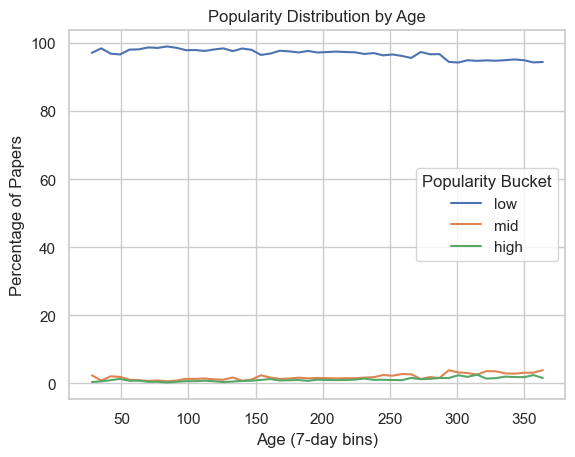

In [18]:
pivot_pct.plot()


plt.xlabel("Age (7-day bins)")
plt.ylabel("Percentage of Papers")
plt.title("Popularity Distribution by Age")
plt.legend(title="Popularity Bucket")
plt.show()


## Exponential Threshold

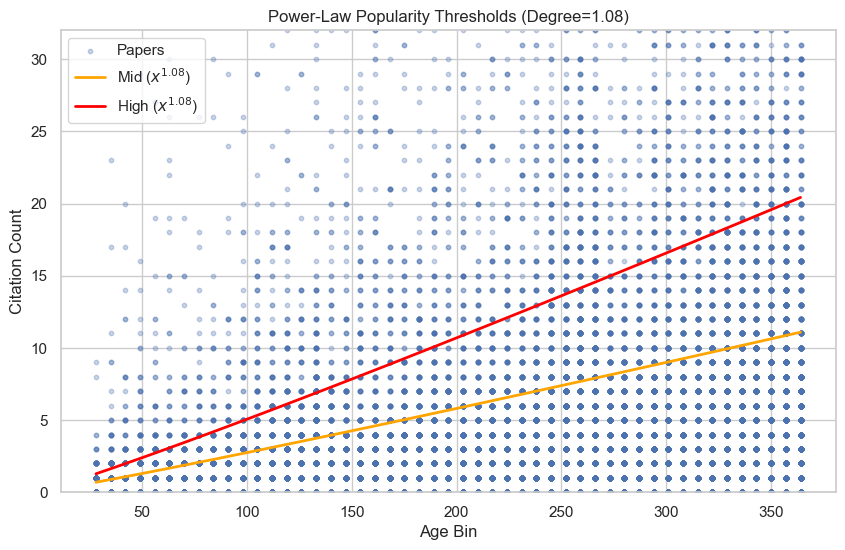

popularity_bucket,low,mid,high
age_bin,,,
28,89.628821,7.532751,2.838428
35,86.387435,9.773124,3.839442
42,94.237013,0.000000,5.762987
49,94.267139,2.423168,3.309693
56,93.723629,3.059072,3.217300
63,93.974026,4.207792,1.818182
70,93.307655,4.718344,1.974001
77,96.947859,1.144553,1.907588
84,96.932515,1.840491,1.226994


In [19]:
# 1. Choose your growth "degree" (exponent)
# degree = 1.0  -> Linear
# degree = 1.5  -> Between Linear and Quadratic
# degree = 2.0  -> Quadratic
degree = 1.08

# 2. Adjust constants
# As you increase the degree, decrease these constants to keep the curve reasonable
c1 = 0.019   # Threshold for 'mid'
c2 = 0.035   # Threshold for 'high'

# Power Law Thresholding: c * (age ^ degree)
mid_threshold = c1 * (df['age_bin'] ** degree)
high_threshold = c2 * (df['age_bin'] ** degree)

# Apply thresholds
conditions = [
    df['citation_count'] < mid_threshold,
    (df['citation_count'] >= mid_threshold) & (df['citation_count'] < high_threshold),
    df['citation_count'] >= high_threshold
]

choices = ['low', 'mid', 'high']

df['popularity_bucket'] = np.select(conditions, choices, default='low')

# --- Visual Validation ---
plt.figure(figsize=(10, 6))
plt.scatter(df['age_bin'], df['citation_count'], alpha=0.3, label='Papers', s=10)

x_range = np.linspace(df['age_bin'].min(), df['age_bin'].max(), 100)
plt.plot(x_range, c1 * (x_range ** degree), color='orange', linewidth=2, label=f'Mid ($x^{{{degree}}}$)')
plt.plot(x_range, c2 * (x_range ** degree), color='red', linewidth=2, label=f'High ($x^{{{degree}}}$)')

plt.title(f"Power-Law Popularity Thresholds (Degree={degree})")
plt.xlabel("Age Bin")
plt.ylabel("Citation Count")
plt.ylim(0, df['citation_count'].quantile(0.99)) # Zoom to ignore extreme outliers
plt.legend()
plt.show()

# --- Pivot Table ---
pivot_df = (
    df.groupby(['age_bin', 'popularity_bucket'])
      .size()
      .unstack(fill_value=0)
)
pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_pct = pivot_pct[['low', 'mid', 'high']]
pivot_pct

In [24]:
paper_df = df[df['age_days']>200]

In [25]:
len(paper_df)

50327

## Feature Engineering

In [20]:
import re
import numpy as np
import pandas as pd

_WORD_RE = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?")
_SENT_SPLIT_RE = re.compile(r"[.!?]+\s+")
_URL_RE = re.compile(r"https?://\S+|www\.\S+")
_EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")

def add_offline_paper_features(
    df: pd.DataFrame,
    *,
    title_col: str = "title",
    abstract_col: str = "abstract",
    authors_col: str = "authors",
    primary_cat_col: str = "primary_category",
    all_cats_col: str = "all_categories",
    published_at_col: str = "published_at",
    author_sep: str = "|",
) -> pd.DataFrame:
    """
    Add offline-only features for impact prediction.
    No internet calls; relies only on existing metadata/text.

    Returns a copy of df with additional feature columns.
    """
    out = df.copy()

    # ---------- Helpers ----------
    def safe_str(s) -> str:
        return "" if pd.isna(s) else str(s)

    def words(s: str):
        return _WORD_RE.findall(s)

    def sentence_count(s: str) -> int:
        s = s.strip()
        if not s:
            return 0
        # Rough: split on punctuation boundaries
        return max(1, len(_SENT_SPLIT_RE.split(s)))

    def keyword_flags(text_lower: str, patterns: dict) -> dict:
        return {name: int(bool(re.search(pat, text_lower))) for name, pat in patterns.items()}

    # ---------- Parse datetime ----------
    if published_at_col in out.columns:
        dt = pd.to_datetime(out[published_at_col], errors="coerce", utc=True)
        out["pub_hour_utc"] = dt.dt.hour
        out["pub_dow"] = dt.dt.dayofweek          # 0=Mon
        out["pub_month"] = dt.dt.month
        out["is_weekend"] = dt.dt.dayofweek.isin([5, 6]).astype("Int64")

    # ---------- Category features ----------
    if all_cats_col in out.columns:
        cats = out[all_cats_col].fillna("").astype(str)
        out["num_categories"] = cats.apply(lambda x: 0 if x.strip() == "" else len([c for c in x.split("|") if c.strip()]))
        out["is_cross_listed"] = (out["num_categories"] > 1).astype("Int64")

        # Simple category family flags
        def starts_with(prefix: str):
            return cats.apply(lambda x: int(any(c.strip().startswith(prefix) for c in x.split("|") if c.strip())))
        out["has_cs"] = starts_with("cs.")
        out["has_stat"] = starts_with("stat.")
        out["has_math"] = starts_with("math.")
        out["has_eess"] = starts_with("eess.")
        out["has_qbio"] = starts_with("q-bio.")

    if primary_cat_col in out.columns:
        pc = out[primary_cat_col].fillna("").astype(str)
        out["primary_is_cs"] = pc.str.startswith("cs.").astype("Int64")
        out["primary_is_stat"] = pc.str.startswith("stat.").astype("Int64")

    # ---------- Author features ----------
    if authors_col in out.columns:
        auth = out[authors_col].fillna("").astype(str)

        # Split authors
        author_lists = auth.apply(lambda x: [a.strip() for a in x.split(author_sep) if a.strip()])
        out["num_authors_offline"] = author_lists.apply(len)

        out["first_author"] = author_lists.apply(lambda xs: xs[0] if len(xs) else "")
        out["last_author"] = author_lists.apply(lambda xs: xs[-1] if len(xs) else "")

        # Name-length stats (proxy for non-western tokenization / formatting differences)
        author_name_lens = author_lists.apply(lambda xs: [len(a) for a in xs] if xs else [])
        out["author_name_len_mean"] = author_name_lens.apply(lambda ls: float(np.mean(ls)) if ls else np.nan)
        out["author_name_len_max"] = author_name_lens.apply(lambda ls: float(np.max(ls)) if ls else np.nan)

        # Simple signals
        out["has_many_authors_ge5"] = (out["num_authors_offline"] >= 5).astype("Int64")
        out["has_many_authors_ge10"] = (out["num_authors_offline"] >= 10).astype("Int64")

    # ---------- Text features ----------
    title = out.get(title_col, "").apply(safe_str)
    abstract = out.get(abstract_col, "").apply(safe_str)

    title_lower = title.str.lower()
    abs_lower = abstract.str.lower()

    # Basic lengths
    out["title_char_len"] = title.str.len()
    out["abstract_char_len"] = abstract.str.len()

    out["title_word_count"] = title.apply(lambda s: len(words(s)))
    out["abstract_word_count"] = abstract.apply(lambda s: len(words(s)))

    # Avg word length
    out["title_avg_word_len"] = title.apply(lambda s: np.mean([len(w) for w in words(s)]) if words(s) else np.nan)
    out["abstract_avg_word_len"] = abstract.apply(lambda s: np.mean([len(w) for w in words(s)]) if words(s) else np.nan)

    # Sentence counts + avg sentence length (words)
    out["abstract_sentence_count"] = abstract.apply(sentence_count)
    out["abstract_avg_words_per_sentence"] = (
        out["abstract_word_count"] / out["abstract_sentence_count"].replace(0, np.nan)
    )

    # Punctuation / digit ratios
    def ratio_of(pattern: str, s: str) -> float:
        if not s:
            return 0.0
        return len(re.findall(pattern, s)) / max(1, len(s))

    out["title_digit_ratio"] = title.apply(lambda s: ratio_of(r"\d", s))
    out["abstract_digit_ratio"] = abstract.apply(lambda s: ratio_of(r"\d", s))
    out["title_punct_ratio"] = title.apply(lambda s: ratio_of(r"[^\w\s]", s))
    out["abstract_punct_ratio"] = abstract.apply(lambda s: ratio_of(r"[^\w\s]", s))

    # URL/email presence
    out["abstract_has_url"] = abstract.apply(lambda s: int(bool(_URL_RE.search(s)))).astype("Int64")
    out["abstract_has_email"] = abstract.apply(lambda s: int(bool(_EMAIL_RE.search(s)))).astype("Int64")

    # Specific link/identifier flags
    out["mentions_github"] = abs_lower.str.contains("github.com", regex=False).astype("Int64")
    out["mentions_code"] = abs_lower.str.contains("code", regex=False).astype("Int64")
    out["mentions_dataset"] = abs_lower.str.contains("dataset", regex=False).astype("Int64")
    out["mentions_benchmark"] = abs_lower.str.contains("benchmark", regex=False).astype("Int64")
    out["mentions_arxiv_id"] = abs_lower.str.contains("arxiv", regex=False).astype("Int64")
    out["mentions_doi"] = abs_lower.str.contains("doi", regex=False).astype("Int64")

    # Keyword patterns (title+abstract)
    kw_patterns = {
        # format / type
        "is_survey": r"\bsurvey\b|\breview\b",
        "is_benchmark_paper": r"\bbenchmark\b|\bleaderboard\b",
        "is_dataset_paper": r"\bdataset\b|\bcorpus\b",
        "is_system_paper": r"\bsystem\b|\bframework\b|\bplatform\b",
        "has_theory": r"\btheorem\b|\bproof\b|\bconvergence\b",

        # hot topics
        "mentions_llm": r"\bllm\b|large language model|language model",
        "mentions_diffusion": r"\bdiffusion\b",
        "mentions_transformer": r"\btransformer\b",
        "mentions_agent": r"\bagent\b|\btool\b|\bplanning\b",
        "mentions_rl": r"\breinforcement learning\b|\brl\b",
        "mentions_multimodal": r"\bmultimodal\b|vision-language|vlm",

        # “impact-ish” phrasing
        "claims_sota": r"\bsota\b|state[- ]of[- ]the[- ]art",
        "claims_novel": r"\bnovel\b|\bnew\b|\bfirst\b|\bintroduce\b",
        "mentions_open_source": r"open[- ]source|we release|code is available",
        "mentions_experiments": r"\bexperiments?\b|\bwe evaluate\b|\bresults?\b",
    }

    # Apply to concatenated text
    combined_lower = (title_lower + " " + abs_lower).fillna("")
    kw_df = pd.DataFrame(
        combined_lower.apply(lambda s: keyword_flags(s, kw_patterns)).tolist(),
        index=out.index,
    )
    out = pd.concat([out, kw_df], axis=1)

    # Lexical diversity proxy (type-token ratio) on abstract
    def ttr(s: str) -> float:
        ws = [w.lower() for w in words(s)]
        if not ws:
            return np.nan
        return len(set(ws)) / len(ws)

    out["abstract_ttr"] = abstract.apply(ttr)

    # Optional: log transforms for stability (often helps tree models)
    out["log_abstract_word_count"] = np.log1p(out["abstract_word_count"])
    out["log_num_authors"] = np.log1p(out.get("num_authors_offline", 0))

    return out


In [21]:
# df_feat = add_offline_paper_features(paper_df)
# df_feat.columns  # inspect new features


## Prepare Dataframe

In [22]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from xgboost import XGBClassifier

In [26]:
# ============================================================
# 1) Feature engineering (offline only)
# ============================================================
paper_feat_df = add_offline_paper_features(paper_df)

# Optional: sanity check
# print(paper_feat_df.columns)

In [19]:
# ============================================================
# 2) Filter to matured labels (so target is meaningful)
# ============================================================
model_df = paper_feat_df[paper_feat_df["age_days"] >= 200].copy()

# Target
y = model_df["popularity_bucket"].astype(str)

In [136]:
# ============================================================
# 3) Build X (drop leakage + non-features)
#    IMPORTANT: Don't use citation_count / age_days / age_bin
# ============================================================
leak_cols = {
    "popularity_bucket",
    "citation_count",
    "age_days",
    "age_bin",
}

# Also drop identifiers that usually won't generalize (optional)
id_cols = {"arxiv_id"}  # keep if you want; I recommend dropping
drop_cols = leak_cols | id_cols

X = model_df.drop(columns=[c for c in drop_cols if c in model_df.columns])


In [137]:
# ============================================================
# 4) Train/test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [149]:
# ============================================================
# 5) Preprocessing setup
#    - text: TF-IDF on title + abstract
#    - categorical: one-hot
#    - numeric: median impute
# ============================================================
text_title_col = "title" if "title" in X_train.columns else None
text_abs_col = "abstract" if "abstract" in X_train.columns else None

# Categorical columns (object dtype) except text
object_cols = X_train.select_dtypes(include=["object", "string"]).columns.tolist()
cat_cols = [c for c in object_cols if c not in {text_title_col, text_abs_col}]

# Numeric columns
num_cols = X_train.select_dtypes(include=["int64", "int32", "float64", "float32"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])


to_1d = FunctionTransformer(lambda x: x.ravel(), validate=False)

title_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="")),
    ("to_1d", to_1d),
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)),
])

abstract_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="")),
    ("to_1d", to_1d),
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1, 2), min_df=2)),
])

transformers = []
if num_cols:
    transformers.append(("num", numeric_transformer, num_cols))
if cat_cols:
    transformers.append(("cat", categorical_transformer, cat_cols))
if text_title_col:
    transformers.append(("title", title_transformer, [text_title_col]))
if text_abs_col:
    transformers.append(("abstract", abstract_transformer, [text_abs_col]))


preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.3
)

In [150]:
import pandas as pd
import numpy as np

def debug_preprocess_inputs(X_train, preprocess, text_title_col="title", text_abs_col="abstract"):
    print("=== Basic X_train info ===")
    print("X_train type:", type(X_train))
    print("X_train shape:", getattr(X_train, "shape", None))
    print("X_train columns:", list(X_train.columns)[:20], "..." if len(X_train.columns) > 20 else "")
    print()

    # Show suspect columns existence and shapes
    for col in [text_title_col, text_abs_col]:
        if col in X_train.columns:
            print(f"--- Column check: {col} ---")
            print("dtype:", X_train[col].dtype)
            print("is Series:", isinstance(X_train[col], pd.Series))
            print("Series shape:", X_train[col].shape)
            print("DataFrame shape:", X_train[[col]].shape)
            print("Example value:", X_train[col].iloc[0] if len(X_train) else None)
            print()

    # Inspect ColumnTransformer config
    print("=== ColumnTransformer transformers_ (configured) ===")
    for name, trans, cols in preprocess.transformers:
        print(f"[{name}] cols={cols}  (type={type(cols)})  transformer={type(trans)}")
    print()

    # Try transforming each block separately to see which fails
    print("=== Dry-run per transformer ===")
    for name, trans, cols in preprocess.transformers:
        try:
            X_part = X_train[cols] if isinstance(cols, list) else X_train[cols]
            # Note: If cols is a string, X_train[cols] is a Series (1D) -> common failure path.
            print(f"Trying transformer '{name}' with cols={cols} -> selected type={type(X_part)}, shape={getattr(X_part, 'shape', None)}")
            Xt = trans.fit_transform(X_part)
            print(f"  ✅ success: output type={type(Xt)}, shape={getattr(Xt, 'shape', None)}")
        except Exception as e:
            print(f"  ❌ FAILED transformer '{name}' with cols={cols}")
            print("     Error:", repr(e))
    print()

    # Try the whole preprocess
    print("=== Dry-run full preprocess ===")
    try:
        Xt_all = preprocess.fit_transform(X_train)
        print("✅ preprocess.fit_transform success. Output shape:", getattr(Xt_all, "shape", None))
    except Exception as e:
        print("❌ preprocess.fit_transform FAILED")
        print("Error:", repr(e))


In [151]:
debug_preprocess_inputs(X_train, preprocess)


=== Basic X_train info ===
X_train type: <class 'pandas.DataFrame'>
X_train shape: (39606, 67)
X_train columns: ['title', 'abstract', 'authors', 'primary_category', 'all_categories', 'published_at', 'title_len', 'abstract_len', 'num_authors', 'pub_hour_utc', 'pub_dow', 'pub_month', 'is_weekend', 'num_categories', 'is_cross_listed', 'has_cs', 'has_stat', 'has_math', 'has_eess', 'has_qbio'] ...

--- Column check: title ---
dtype: str
is Series: True
Series shape: (39606,)
DataFrame shape: (39606, 1)
Example value: MEMFOF: High-Resolution Training for Memory-Efficient Multi-Frame Optical Flow Estimation

--- Column check: abstract ---
dtype: str
is Series: True
Series shape: (39606,)
DataFrame shape: (39606, 1)
Example value: Recent advances in optical flow estimation have prioritized accuracy at the cost of growing GPU memory consumption, particularly for high-resolution (FullHD) inputs. We introduce MEMFOF, a memory-efficient multi-frame optical flow method that identifies a favorable t

In [155]:
# ============================================================
# 6) XGBoost model
# ============================================================
# Define ordered categories
ordered_classes = ["low", "mid", "high"]

# Convert to ordered categorical
y_train_cat = pd.Categorical(y_train, categories=ordered_classes, ordered=True)
y_test_cat  = pd.Categorical(y_test, categories=ordered_classes, ordered=True)

# Convert to numeric codes (low=0, mid=1, high=2)
y_train_enc = y_train_cat.codes
y_test_enc  = y_test_cat.codes


xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", xgb),
])

model.fit(X_train, y_train_enc)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [157]:
ordered_classes = ["low", "mid", "high"]


In [158]:
# ============================================================
# 7) Evaluate
# ============================================================
y_pred_enc = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test_enc, y_pred_enc))
print("Macro F1:", f1_score(y_test_enc, y_pred_enc, average="macro"))
print("\nClassification report:\n")
print(classification_report(y_test_enc, y_pred_enc, target_names=ordered_classes))

cm = confusion_matrix(y_test_enc, y_pred_enc, labels=[0, 1, 2])
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in ordered_classes],
    columns=[f"pred_{c}" for c in ordered_classes],
)
print("\nConfusion matrix:\n")
print(cm_df)



Accuracy: 0.902746919814179
Macro F1: 0.41916936888118245

Classification report:

              precision    recall  f1-score   support

         low       0.91      0.99      0.95      8892
         mid       0.08      0.00      0.00       549
        high       0.60      0.20      0.30       461

    accuracy                           0.90      9902
   macro avg       0.53      0.40      0.42      9902
weighted avg       0.85      0.90      0.87      9902


Confusion matrix:

           pred_low  pred_mid  pred_high
true_low       8844         5         43
true_mid        528         1         20
true_high       360         7         94


## Correct Imbalance

In [159]:
# ============================================================
# Step 0) Imports
# ============================================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [160]:
# ============================================================
# Step 1) Feature engineering (offline-only)
# - assumes add_offline_paper_features(paper_df) is already defined
# ============================================================
paper_feat_df = add_offline_paper_features(paper_df)

# Use only "mature" labels for training (your maturity horizon)
model_df = paper_feat_df[paper_feat_df["age_days"] >= 200].copy()

# Target (string labels)
y = model_df["popularity_bucket"].astype(str)

# Drop leakage columns + ids
drop_cols = {"popularity_bucket", "citation_count", "age_days", "age_bin", "arxiv_id"}
X = model_df.drop(columns=[c for c in drop_cols if c in model_df.columns])


In [161]:
# ============================================================
# Step 2) Train/test split (stratified)
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [162]:
# ============================================================
# Step 3) Ordered label encoding (low < mid < high)
# ============================================================
ordered_classes = ["low", "mid", "high"]

y_train_cat = pd.Categorical(y_train, categories=ordered_classes, ordered=True)
y_test_cat  = pd.Categorical(y_test,  categories=ordered_classes, ordered=True)

y_train_enc = y_train_cat.codes
y_test_enc  = y_test_cat.codes

# Safety check: if -1 appears, you have unexpected labels
if (y_train_enc == -1).any() or (y_test_enc == -1).any():
    bad_train = set(pd.Series(y_train).unique()) - set(ordered_classes)
    bad_test  = set(pd.Series(y_test).unique()) - set(ordered_classes)
    raise ValueError(f"Unexpected labels found. Train extras={bad_train}, Test extras={bad_test}")


In [163]:
# ============================================================
# Step 4) Class weights (to fight imbalance) -> sample weights
# ============================================================
classes = np.array([0, 1, 2])  # low, mid, high

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_enc
)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

sample_weights = np.array([class_weight_dict[i] for i in y_train_enc])


Class weights: {np.int64(0): np.float64(0.37119721081932183), np.int64(1): np.float64(6.00910332271279), np.int64(2): np.float64(7.16332067281606)}


In [164]:
# ============================================================
# Step 5) Preprocessing
# - Numeric: median impute
# - Categorical: ONE-HOT but keep it LOW-cardinality
# - Text: TF-IDF on title + abstract
#
# IMPORTANT CHANGE:
#   Do NOT one-hot 'authors' / 'first_author' / 'last_author' / 'all_categories'
#   (they explode dimensionality & hurt minority learning)
# ============================================================
text_title_col = "title" if "title" in X_train.columns else None
text_abs_col   = "abstract" if "abstract" in X_train.columns else None

# Only keep low-cardinality categorical features
cat_cols = []
if "primary_category" in X_train.columns:
    cat_cols = ["primary_category"]

# Numeric columns: everything numeric except leakage already removed
num_cols = X_train.select_dtypes(include=["int64", "int32", "float64", "float32", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

to_1d = FunctionTransformer(lambda x: x.ravel(), validate=False)

title_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="")),
    ("to_1d", to_1d),
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)),
])

abstract_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="")),
    ("to_1d", to_1d),
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1, 2), min_df=2)),
])

transformers = []
if num_cols:
    transformers.append(("num", numeric_transformer, num_cols))
if cat_cols:
    transformers.append(("cat", categorical_transformer, cat_cols))
if text_title_col:
    transformers.append(("title", title_transformer, [text_title_col]))     # list-of-one important!
if text_abs_col:
    transformers.append(("abstract", abstract_transformer, [text_abs_col])) # list-of-one important!

preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.3
)

# Quick sanity check: preprocess should run
Xt_tmp = preprocess.fit_transform(X_train)
print("Preprocess output shape:", Xt_tmp.shape)


Preprocess output shape: (39606, 70184)


In [165]:
# ============================================================
# Step 6) XGBoost (multiclass) + fit with sample weights
# ============================================================
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", xgb),
])

model.fit(X_train, y_train_enc, clf__sample_weight=sample_weights)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [166]:
# ============================================================
# Step 7) Evaluate (encoded + readable labels)
# ============================================================
y_pred_enc = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test_enc, y_pred_enc))
print("Macro F1:", f1_score(y_test_enc, y_pred_enc, average="macro"))
print("\nClassification report:\n")
print(classification_report(
    y_test_enc,
    y_pred_enc,
    labels=[0, 1, 2],
    target_names=ordered_classes
))

cm = confusion_matrix(y_test_enc, y_pred_enc, labels=[0, 1, 2])
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in ordered_classes],
    columns=[f"pred_{c}" for c in ordered_classes],
)
print("\nConfusion matrix:\n")
print(cm_df)


Accuracy: 0.8556857200565542
Macro F1: 0.5013246112742732

Classification report:

              precision    recall  f1-score   support

         low       0.94      0.92      0.93      8892
         mid       0.17      0.20      0.18       549
        high       0.34      0.46      0.39       461

    accuracy                           0.86      9902
   macro avg       0.48      0.53      0.50      9902
weighted avg       0.87      0.86      0.86      9902


Confusion matrix:

           pred_low  pred_mid  pred_high
true_low       8150       436        306
true_mid        324       109        116
true_high       152        95        214


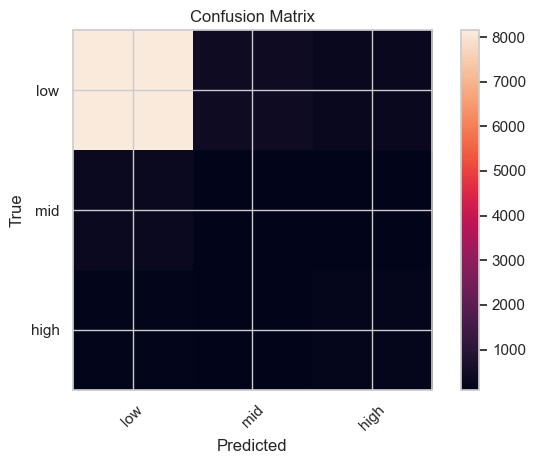

In [167]:
# ============================================================
# Step 8) (Optional) Plot confusion matrix
# ============================================================
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(3), ordered_classes, rotation=45)
plt.yticks(range(3), ordered_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [168]:
# ============================================================
# Step 9) (Optional) Probability + threshold tuning scaffold
# - useful if you want to boost mid/high recall at cost of low precision
# ============================================================
proba = model.predict_proba(X_test)  # shape: (n, 3)

# naive argmax baseline:
y_pred_argmax = np.argmax(proba, axis=1)

# Example: raise sensitivity to "high"
# predict high if P(high) >= 0.35, else argmax
high_thresh = 0.35
y_pred_tuned = y_pred_argmax.copy()
y_pred_tuned[proba[:, 2] >= high_thresh] = 2

print("Macro F1 (argmax):", f1_score(y_test_enc, y_pred_argmax, average="macro"))
print("Macro F1 (tuned):", f1_score(y_test_enc, y_pred_tuned, average="macro"))


Macro F1 (argmax): 0.5013246112742732
Macro F1 (tuned): 0.4933021941301899


## Semantic Embedding

In [27]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

import torch
from sentence_transformers import SentenceTransformer


In [28]:
# --- Determinism / reproducibility ---
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# If you ever use GPU and want more determinism:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [29]:
import os

# Hard cap threads to avoid libomp crashes on macOS
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Optional: make tokenizers not spawn extra threads
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [31]:
import torch
torch.set_num_threads(1)
torch.set_num_interop_threads(1)


RuntimeError: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called

In [ ]:
paper_feat_df = add_offline_paper_features(paper_df)

# Train only on matured labels (your horizon)
model_df = paper_feat_df[paper_feat_df["age_days"] >= 200].copy()

# Target (string)
y = model_df["popularity_bucket"].astype(str)

# Drop leakage columns + IDs
drop_cols = {"popularity_bucket", "citation_count", "age_days", "age_bin", "arxiv_id"}
X = model_df.drop(columns=[c for c in drop_cols if c in model_df.columns])


In [ ]:
ordered_classes = ["low", "mid", "high"]

y_cat = pd.Categorical(y, categories=ordered_classes, ordered=True)
y_enc = y_cat.codes

# Safety check: -1 means unexpected labels
if (y_enc == -1).any():
    extras = set(pd.Series(y).unique()) - set(ordered_classes)
    raise ValueError(f"Unexpected labels found: {extras}")


In [ ]:
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=SEED,
    stratify=y_enc
)


In [ ]:
# Text columns
TITLE_COL = "title"
ABSTRACT_COL = "abstract"

# Keep only low-cardinality categorical feature(s)
cat_cols = []
if "primary_category" in X_train.columns:
    cat_cols = ["primary_category"]

# Numeric columns (all numeric/bool)
num_cols = X_train.select_dtypes(include=["int64","int32","float64","float32","bool"]).columns.tolist()

# IMPORTANT: remove text columns from num_cols if they were mistakenly included
num_cols = [c for c in num_cols if c not in {TITLE_COL, ABSTRACT_COL}]


: 

In [ ]:
import numpy as np
import pandas as pd
import os

def encode_in_chunks(model, texts: pd.Series, out_path: str, chunk_size=2000, batch_size=16, max_chars=6000):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    texts = texts.fillna("").astype(str).str.slice(0, max_chars)

    all_emb = []
    n = len(texts)

    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        print(f"Encoding {start}:{end} ...")

        chunk = texts.iloc[start:end].tolist()
        emb = model.encode(
            chunk,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True,
        ).astype(np.float32)

        all_emb.append(emb)
        cur = np.vstack(all_emb)
        np.save(out_path, cur)
        print("Saved:", cur.shape)

    return np.load(out_path)

# Example usage:
train_texts = (X_train["title"].fillna("").astype(str) + " [SEP] " + X_train["abstract"].fillna("").astype(str))
X_train_emb = encode_in_chunks(st_model, train_texts, "./emb_cache/train_emb.npy")
print("Train emb:", X_train_emb.shape)


NameError: name 'X_train' is not defined

In [ ]:
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
CACHE_DIR = "./emb_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def build_text_block(df: pd.DataFrame) -> pd.Series:
    title = df.get(TITLE_COL, "").fillna("").astype(str)
    abstract = df.get(ABSTRACT_COL, "").fillna("").astype(str)
    return title + " [SEP] " + abstract

def get_cached_embeddings(texts: pd.Series, cache_path: str, model_name: str, batch_size: int = 16) -> np.ndarray:
    """
    Returns embeddings in the same order as `texts`.
    Caches to .npy at cache_path.
    """
    if os.path.exists(cache_path):
        emb = np.load(cache_path)
        # Basic sanity check
        if emb.shape[0] == len(texts):
            return emb
        else:
            print("Cache shape mismatch, recomputing embeddings...")

    # CPU for best determinism
    st_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")

    emb = st_model.encode(
        texts.tolist(),
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,   # good for cosine-like geometry
    ).astype(np.float32)

    np.save(cache_path, emb)
    return emb

# Build texts
train_texts = build_text_block(X_train)
test_texts  = build_text_block(X_test)

# Cache filenames (tie to dataset sizes)
train_cache = os.path.join(CACHE_DIR, f"emb_train_{len(X_train)}_{EMB_MODEL_NAME.replace('/','_')}.npy")
test_cache  = os.path.join(CACHE_DIR, f"emb_test_{len(X_test)}_{EMB_MODEL_NAME.replace('/','_')}.npy")

X_train_emb = get_cached_embeddings(train_texts, train_cache, EMB_MODEL_NAME, batch_size=64)
X_test_emb  = get_cached_embeddings(test_texts, test_cache, EMB_MODEL_NAME, batch_size=64)

print("Train emb shape:", X_train_emb.shape)
print("Test emb shape:", X_test_emb.shape)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/630 [00:00<?, ?it/s]

: 

: 

In [ ]:
# ---- Numeric ----
num_imputer = SimpleImputer(strategy="median")
X_train_num = num_imputer.fit_transform(X_train[num_cols]) if num_cols else np.zeros((len(X_train), 0), dtype=np.float32)
X_test_num  = num_imputer.transform(X_test[num_cols]) if num_cols else np.zeros((len(X_test), 0), dtype=np.float32)

# ---- Categorical (low-cardinality only) ----
if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_train_cat_raw = cat_imputer.fit_transform(X_train[cat_cols])
    X_test_cat_raw  = cat_imputer.transform(X_test[cat_cols])

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train_cat_raw).astype(np.float32)
    X_test_cat  = ohe.transform(X_test_cat_raw).astype(np.float32)
else:
    X_train_cat = np.zeros((len(X_train), 0), dtype=np.float32)
    X_test_cat  = np.zeros((len(X_test), 0), dtype=np.float32)

# ---- Final feature matrix ----
X_train_final = np.hstack([X_train_emb, X_train_num.astype(np.float32), X_train_cat])
X_test_final  = np.hstack([X_test_emb,  X_test_num.astype(np.float32),  X_test_cat])

print("X_train_final:", X_train_final.shape)
print("X_test_final :", X_test_final.shape)


In [ ]:
classes = np.array([0, 1, 2])  # low, mid, high

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_enc
)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

sample_weights = np.array([class_weight_dict[int(i)] for i in y_train_enc], dtype=np.float32)


In [ ]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=900,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    reg_lambda=2.0,
    random_state=SEED,
    n_jobs=-1,
)

xgb.fit(X_train_final, y_train_enc, sample_weight=sample_weights)


In [ ]:
y_pred_enc = xgb.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test_enc, y_pred_enc))
print("Macro F1:", f1_score(y_test_enc, y_pred_enc, average="macro"))
print("\nClassification report:\n")
print(classification_report(
    y_test_enc, y_pred_enc,
    labels=[0,1,2],
    target_names=ordered_classes
))

cm = confusion_matrix(y_test_enc, y_pred_enc, labels=[0,1,2])
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in ordered_classes],
    columns=[f"pred_{c}" for c in ordered_classes],
)
print("\nConfusion matrix:\n")
print(cm_df)


In [ ]:
proba = xgb.predict_proba(X_test_final)  # (n, 3)

# argmax baseline
y_pred_argmax = np.argmax(proba, axis=1)

# example: push more "high" predictions
high_thresh = 0.35
y_pred_tuned = y_pred_argmax.copy()
y_pred_tuned[proba[:, 2] >= high_thresh] = 2

print("Macro F1 (argmax):", f1_score(y_test_enc, y_pred_argmax, average="macro"))
print("Macro F1 (tuned):", f1_score(y_test_enc, y_pred_tuned, average="macro"))
